In [1]:
from nltk.grammar import CFG
from nltk.parse import ChartParser

grammar = CFG.fromstring(f"""
    # грамматика запроса
    S -> QG | PR
    
    # общие вопросы
    QG -> QG1 | QG2 | QG3 | QG4
    
    # запросты-предпочтения
    PR -> PR1
    
    # Общий вопрос №1 -----------------------------------------------
    # вопрос про количество аниме в базе
    QG1 -> HowMany 'чего' 'есть' OptionalQuestionMark
    QG1 -> HowMany AnimeNounSP OptionalQuestionMark
    QG1 -> HowMany AnimeNounSP ContainsIn Database OptionalQuestionMark
    
    # фраза, означающая вопросительное "сколько?"
    HowMany -> 'сколько' | 'много' | 'много' 'ли'
    
    # фраза, означающая одно или несколько аниме
    AnimeNounSP -> AnimeNounS | AnimeNounP
    AnimeNounS -> 'аниме' | 'аниме' 'фильм' | 'аниме' 'сериал'
    AnimeNounP -> 'аниме' 'фильмы' | 'аниме' 'сериалы'
    
    # фраза, означающая содержание чего-то в чем-то
    ContainsIn -> Contains | Contains 'в' | 'в'
    Contains -> 'храниться' | 'содержаться' | 'находиться' | 'представить'
    
    # База данных
    Database -> 'база' | 'база' 'данные' | 'хранилище' | 'память'

    # Общий вопрос №2 -----------------------------------------------
    # вопрос про количество жанров в базе
    QG2 -> HowMany GenreNoun OptionalQuestionMark
    QG2 -> HowMany GenreNoun ContainsIn Database OptionalQuestionMark
    QG2 -> 'какой' GenreNoun ContainsIn Database OptionalQuestionMark
    
    GenreNoun -> 'жанр' | 'жанры'
    
    # Общий вопрос №3 -----------------------------------------------
    # вопрос про смысл конкретного жанра
    QG3 -> ConcreteGenre Is What OptionalQuestionMark
    QG3 -> 'что' 'представлять' 'жанр' ConcreteGenre OptionalQuestionMark
    
    Is -> '-' | 'это' | '-' 'это'
    What -> 'что' | 'что' 'такой' | 'ху'
    
    # продукции для определения конкретных жанров
    ConcreteGenre -> '#GENRE#'
    
    # Общий вопрос №4 -----------------------------------------------
    # получение информации по конкретному аниме
    QG4 -> What CanTell About ConcreteAnime OptionalQuestionMark
    
    CanTell -> 'мочь' 'рассказать'
    About -> 'о' | 'обо' | 'про' |
    ConcreteAnime -> '#ANIME#' | AnimeNounS '#ANIME#'
    
    # Запрос-предпочтения №1 ----------------------------------------
    # нравятся жанры
    PR1 -> ILike ConcreteGenreP
    
    ILike -> 'я' Like | Like
    Like -> 'любить' | 'нравиться'
    
    ConcreteGenreP -> ConcreteGenre | ConcreteGenre ConcreteGenreP
    ConcreteGenreP -> ConcreteGenre 'и' ConcreteGenreP
    ConcreteGenreP -> ConcreteGenre ',' ConcreteGenreP

    # опциональный вопросительный знак
    OptionalQuestionMark -> '?' |
""")

parser = ChartParser(grammar)
parser

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from morph import morph
from genreproc import is_genre
from animeapi import ApiServer, AnimeService
from nltk.util import ngrams

keep_stopwords = ('чего', 'что', 'есть', 'много', 'не')
stopwords = list(filter(lambda w: w not in keep_stopwords, stopwords.words('russian')))

stopwords += ['также']

api_server = ApiServer('localhost', '8080')
anime_service = AnimeService(api_server)

def extract_anime_names(tokens: list[str]) -> list:
    if 'аниме' not in tokens:
        return []
    animes = []
    for k in (3, 2, 1):
        for i, ngram in enumerate(ngrams(tokens, k)):
            if 'аниме' in ngram:
                continue
            name = ' '.join(ngram)
            anime = anime_service.find_anime_exact(name)
            if anime is not None:
                tokens[i:i+k] = ['#ANIME#']
                animes.append(((i, k), name, anime))
    if len(animes) > 0:
        print('replaced animes:', animes)
    return animes

def extract_genres(tokens: list[str]) -> list:
    replaced_genres = []
    for i, t in enumerate(tokens):
        prob, gen = is_genre(t)
        print(prob, gen, t)
        if prob > 0.7:
            print('found genre:', t, gen, prob)
            tokens[i] = '#GENRE#'
            replaced_genres.append((i, prob, t, gen))
    if len(replaced_genres) > 0:
        print('replaced genres:', replaced_genres)
    return replaced_genres

def parse_sentense(sentence: str):
    print('input:', sentence)
    tokens = word_tokenize(sentence)
    print('tokens:', tokens)
    tokens = list(filter(lambda w: w not in stopwords, tokens))
    print('filtered tokens:', tokens)
    replaced_animes = extract_anime_names(tokens)
    replaced_genres = extract_genres(tokens)
    stems = [[t] if '#' in t else morph.normal_forms(t) for t in tokens ]
    print('all stems:', stems)
    stems = [s[0] for s in stems]
    print('selected stems:', stems)
    return parser.parse_one(stems)

input: сколько аниме фильмов хранится в базе?
tokens: ['сколько', 'аниме', 'фильмов', 'хранится', 'в', 'базе', '?']
filtered tokens: ['сколько', 'аниме', 'фильмов', 'хранится', 'базе', '?']
all stems: [['сколько'], ['аниме'], ['фильм'], ['храниться'], ['база', 'баз'], ['?']]
selected stems: ['сколько', 'аниме', 'фильм', 'храниться', 'база', '?']


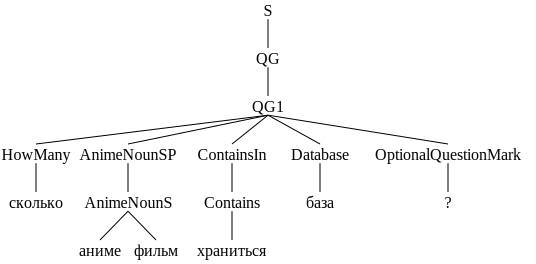

In [25]:
parse_sentense("сколько аниме фильмов хранится в базе?")

input: какие жанры представлены в базе данных
tokens: ['какие', 'жанры', 'представлены', 'в', 'базе', 'данных']
filtered tokens: ['какие', 'жанры', 'представлены', 'базе', 'данных']
all stems: [['какой'], ['жанр'], ['представить'], ['база', 'баз'], ['данные', 'дать', 'данный']]
selected stems: ['какой', 'жанр', 'представить', 'база', 'данные']


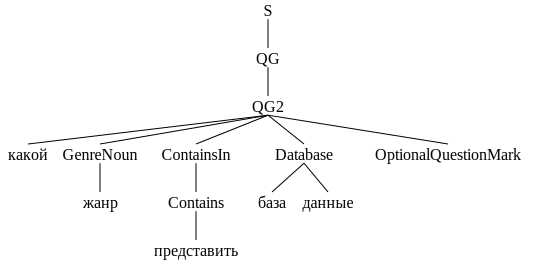

In [17]:
parse_sentense("какие жанры представлены в базе данных")

input: драма - это что такое?
tokens: ['драма', '-', 'это', 'что', 'такое', '?']
filtered tokens: ['драма', '-', 'это', 'что', 'такое', '?']
found genre: драма Drama 1.0
replaced genres: [(0, 1.0, 'драма', 'Drama')]
all stems: [['#GENRE#'], ['-'], ['это', 'этот'], ['что'], ['такой'], ['?']]
selected stems: ['#GENRE#', '-', 'это', 'что', 'такой', '?']


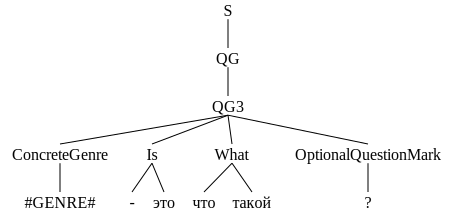

In [18]:
parse_sentense("драма - это что такое?")

input: что из себя представляет жанр драма
tokens: ['что', 'из', 'себя', 'представляет', 'жанр', 'драма']
filtered tokens: ['что', 'представляет', 'жанр', 'драма']
found genre: драма Drama 1.0
replaced genres: [(3, 1.0, 'драма', 'Drama')]
all stems: [['что'], ['представлять'], ['жанр'], ['#GENRE#']]
selected stems: ['что', 'представлять', 'жанр', '#GENRE#']


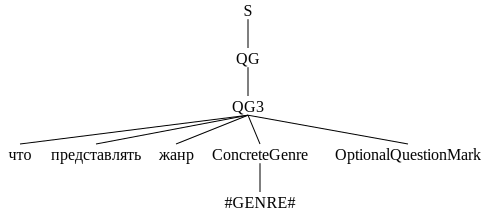

In [19]:
parse_sentense("что из себя представляет жанр драма")

input: Что ты можешь рассказать про аниме Блич?
tokens: ['Что', 'ты', 'можешь', 'рассказать', 'про', 'аниме', 'Блич', '?']
filtered tokens: ['Что', 'можешь', 'рассказать', 'аниме', 'Блич', '?']
replaced animes: [((4, 1), 'Блич', AnimeDTO(id=269, title="Bleach"))]
0.5666666666666667 School Что
0.6000000000000001 Comedy можешь
0  рассказать
0.64 Drama аниме
0.6 Seinen #ANIME#
0.09999999999999998 Cars ?
all stems: [['что'], ['мочь'], ['рассказать'], ['аниме'], ['#ANIME#'], ['?']]
selected stems: ['что', 'мочь', 'рассказать', 'аниме', '#ANIME#', '?']


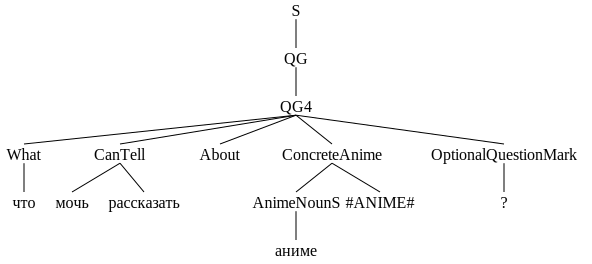

In [4]:
parse_sentense("Что ты можешь рассказать про аниме Блич?")

input: мне нравятся боевики, драма и гонки
tokens: ['мне', 'нравятся', 'боевики', ',', 'драма', 'и', 'гонки']
filtered tokens: ['нравятся', 'боевики', ',', 'драма', 'гонки']
0  нравятся
0.8571428571428572 Martial Arts боевики
found genre: боевики Martial Arts 0.8571428571428572
0.09999999999999998 Cars ,
1.0 Drama драма
found genre: драма Drama 1.0
1.0 Cars гонки
found genre: гонки Cars 1.0
replaced genres: [(1, 0.8571428571428572, 'боевики', 'Martial Arts'), (3, 1.0, 'драма', 'Drama'), (4, 1.0, 'гонки', 'Cars')]
all stems: [['нравиться'], ['#GENRE#'], [','], ['#GENRE#'], ['#GENRE#']]
selected stems: ['нравиться', '#GENRE#', ',', '#GENRE#', '#GENRE#']


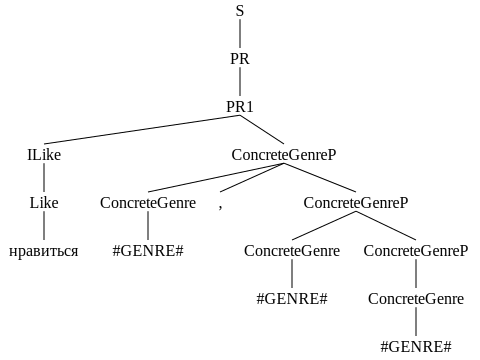

In [3]:
parse_sentense("мне нравятся боевики, драма и гонки")